# ENERGY PRICES

This notebook contains <br>
[0. Import libraries and data](#0.-Import-libraries-and-data) <br>
[1. Building the DataFrame](#1.-Building-the-DataFrame) <br>
[2. Exploring the DataFrame](#2.-Exploring-the-DataFrame) <br>
[3. Modelling the prices](#3.-Modelling-the-prices) <br>

## 0. Import libraries and data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

from pathlib import Path

In [2]:
#working directory
working_dir = !dir()
wd_name = working_dir[3].split(" ")[3]

In [3]:
#The file is downloaded from https://transparency.entsoe.eu/dashboard/show
prices_csv="Day-ahead Prices_201601010000-201701010000.csv"
df_prices = pd.read_csv(prices_csv, sep=",")


One consideration with this data is that the prices have negative values that are going to be kept. This is a consequence of the energy market in Germany, when there are high renewable power supply (lots of wind and sun). For more information visit [this link](https://www.cleanenergywire.org/factsheets/why-power-prices-turn-negative)

## 1. Building the DataFrame

The first thing is to obtain the dates in the proper format.

In [4]:
df_prices['Datetime'] = df_prices[df_prices.columns[0]].map(lambda x: str(x).split("-")[0].rstrip())
df_prices['Datetime'] = pd.to_datetime(df_prices['Datetime'], format='%d.%m.%Y %H:%M')
df_prices.head()


,MTU (UTC),Day-ahead Price [EUR/MWh],Datetime
0,01.01.2016 00:00 - 01.01.2016 01:00,22.39,2016-01-01 00:00:00
1,01.01.2016 01:00 - 01.01.2016 02:00,20.59,2016-01-01 01:00:00
2,01.01.2016 02:00 - 01.01.2016 03:00,16.81,2016-01-01 02:00:00
3,01.01.2016 03:00 - 01.01.2016 04:00,17.41,2016-01-01 03:00:00
4,01.01.2016 04:00 - 01.01.2016 05:00,17.02,2016-01-01 04:00:00


In [5]:
df_prices.dtypes

MTU (UTC)                            object
Day-ahead Price [EUR/MWh]           float64
Datetime                     datetime64[ns]
dtype: object

Only some of the columns are going to be keep and some others will be generated for the next part of the study.

In [6]:
df_prices_clean = pd.DataFrame()
df_prices_clean['Datetime'] = df_prices['Datetime']
df_prices_clean['Price'] = df_prices[df_prices.columns[1]]
df_prices_clean['Date'] =df_prices_clean['Datetime'].map(lambda x: x.date())
df_prices_clean['Hour'] = df_prices_clean['Datetime'].map(lambda x: x.hour)
df_prices_clean['DayofWeek'] = df_prices_clean['Datetime'].map(lambda x: x.dayofweek)
df_prices_clean['DayofWeek_Str'] = df_prices_clean['Datetime'].map(lambda x: x.strftime("%A"))

In [7]:
df_prices_clean.sample(5)

,Datetime,Price,Date,Hour,DayofWeek,DayofWeek_Str
3155,2016-05-11 11:00:00,20.87,2016-05-11,11,2,Wednesday
8310,2016-12-12 06:00:00,57.36,2016-12-12,6,0,Monday
1983,2016-03-23 15:00:00,24.18,2016-03-23,15,2,Wednesday
3374,2016-05-20 14:00:00,24.57,2016-05-20,14,4,Friday
5250,2016-08-06 18:00:00,28.92,2016-08-06,18,5,Saturday


In [8]:
#Prices normalization, dividing by the day mean
df_daymean = pd.DataFrame(df_prices_clean.groupby(df_prices_clean['Date'])['Price'].mean())
df_daymean.rename(columns={'Price' : 'DayMean'},inplace=True)
df_prices_clean = df_prices_clean.merge(df_daymean,left_on='Date', right_on='Date', how='outer')
df_prices_clean['Price_nom'] = df_prices_clean['Price']/df_prices_clean['DayMean']

In [9]:
df_prices_clean.to_csv('Prices.csv')

## 2. Exploring the DataFrame

In [10]:
mean_byhour = df_prices_clean.groupby('Hour').mean()
mean_bydayofweek= df_prices_clean.groupby('DayofWeek').mean()

In [11]:
mean_bydayofweek.head()

,Price,Hour,DayMean,Price_nom
DayofWeek,,,,
0,30.019928,11.5,30.019928,1.0
1,32.166627,11.5,32.166627,1.0
2,31.506707,11.5,31.506707,1.0
3,31.684135,11.5,31.684135,1.0
4,31.032028,11.5,31.032028,1.0


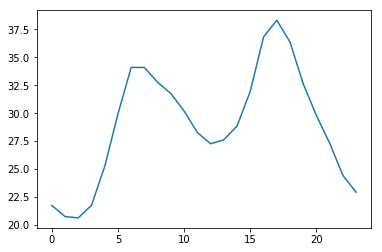

In [12]:
#Mean price for each hour in the whole year
plt.plot(mean_byhour['Price'])

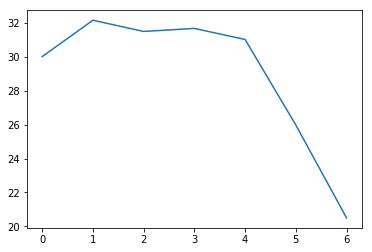

In [13]:
#Mean price for each day of the week (from Monday (0) to Sunday (6))
plt.plot(mean_bydayofweek['Price'])

It can be seen that weekends have the lower prices

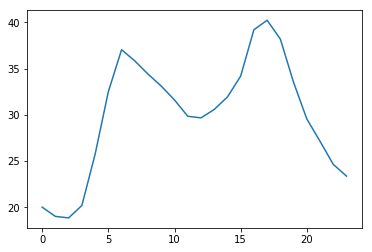

In [14]:
#Shape of the price in a specific day of the week by hour
monday_hours = df_prices_clean[df_prices_clean['DayofWeek']==0].groupby('Hour').mean()
plt.plot(monday_hours['Price'])

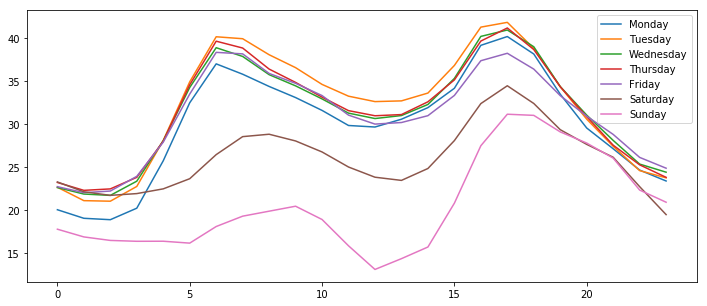

In [15]:
#Plot with the mean price for each hour in each day of the week
plt.figure(figsize=(12,5))
for i in list(range(0,7)):
    day_hours=df_prices_clean[df_prices_clean['DayofWeek']==i].groupby('Hour').mean()
    day_name = df_prices_clean["DayofWeek_Str"][df_prices_clean['DayofWeek']==i].iloc[0]
    plt.plot(day_hours['Price'], label = day_name)
    plt.legend(loc=1)


From the graph it can be seen that there are 3 diferent behaviours:
1. weekdays
2. saturday
1. sunday


## 3. Modelling the prices
With kmeans algorithm the hours will be clustered according to the prices. The 3 behaviours are going to have the same cluster since the shapes of the curves is in consonance, but the mean prices for the weekend are lower.

##### Weekdays

In [16]:
df_weekdays = df_prices_clean[df_prices_clean['DayofWeek'] <=4]
df_weekdays.head()

,Datetime,Price,Date,Hour,DayofWeek,DayofWeek_Str,DayMean,Price_nom
0,2016-01-01 00:00:00,22.39,2016-01-01,0,4,Friday,24.88,0.899920
1,2016-01-01 01:00:00,20.59,2016-01-01,1,4,Friday,24.88,0.827572
2,2016-01-01 02:00:00,16.81,2016-01-01,2,4,Friday,24.88,0.675643
3,2016-01-01 03:00:00,17.41,2016-01-01,3,4,Friday,24.88,0.699759
4,2016-01-01 04:00:00,17.02,2016-01-01,4,4,Friday,24.88,0.684084


In [17]:
df_weekdays.iloc[:,1:4].head()

,Price,Date,Hour
0,22.39,2016-01-01,0
1,20.59,2016-01-01,1
2,16.81,2016-01-01,2
3,17.41,2016-01-01,3
4,17.02,2016-01-01,4


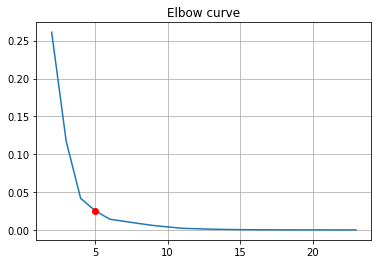

In [18]:
# Data values
df_weekdaysH = df_weekdays.groupby('Hour').mean()
prices = df_weekdaysH['Price_nom'].values
X = np.array(list(zip(prices)))

#Elbow Method to identify the best number of clusters
center_distances = []
for k in list(df_weekdaysH.index[2:]):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    center_distances.append(kmeans.inertia_)

plt.plot(list(df_weekdaysH.index[2:]), center_distances)
plt.grid(True)
plt.title('Elbow curve')

#Given the graph the results the chosen number of clusters is 5
n_clusters = 5
plt.plot(n_clusters,center_distances[n_clusters-2], marker='o', color='r')

Once the number of clusters is set KMeans can be run to group the data

In [19]:
np.random.seed(1)

# Initializing KMeans
kmeans = KMeans(n_clusters=5)
# Fitting with inputs
kmeans = kmeans.fit(X)
# Predicting the clusters
cluster_num = kmeans.predict(X)
# Getting the cluster centers
cluster_centers = kmeans.cluster_centers_
# Add the cluster to a column in the dataframe
df_weekdaysH['Cluster'] = pd.Series(cluster_num, index=df_weekdaysH.index)

In [20]:
df_weekdaysH.head(5)

,Price,DayofWeek,DayMean,Price_nom,Cluster
Hour,,,,,
0,22.245594,2.007663,31.280928,0.708656,4
1,21.259004,2.007663,31.280928,0.661082,4
2,21.253985,2.007663,31.280928,0.656253,4
3,22.811762,2.007663,31.280928,0.714508,4
4,27.572759,2.007663,31.280928,0.904484,2


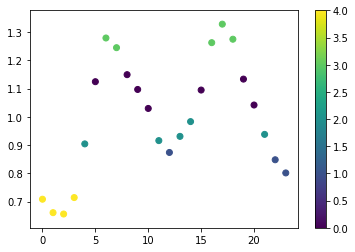

In [21]:
#Plot
X = df_weekdaysH.index
y = df_weekdaysH['Price_nom']
color = df_weekdaysH['Cluster']
plt.scatter(X,y, c= color)
plt.colorbar()

In [22]:
df_weekdaysH.groupby('Cluster').count()

,Price,DayofWeek,DayMean,Price_nom
Cluster,,,,
0,7,7,7,7
1,3,3,3,3
2,5,5,5,5
3,5,5,5,5
4,4,4,4,4


To reference the cluster the following names are given
<p>LowLow Price &#9658; Cluster 4</p>
<p>Low Price &#9658; Cluster 1 </p>
<p>Standard price &#9658; Cluster 2 </p>
<p>High Price &#9658; Cluster 0 </p>
<p>HighHigh Price &#9658; Cluster 3 </p>

In [23]:
cluster_order = [4,1,2,0,3]
f = lambda x: cluster_order.index(x)
f(df_weekdaysH['Cluster'][9])

3

In [24]:
#Cluster_id from low to high (0,4)
df_weekdaysH['Cluster_id'] = df_weekdaysH['Cluster'].map(lambda x: cluster_order.index(x))

In [25]:
df_weekdaysH.head()

,Price,DayofWeek,DayMean,Price_nom,Cluster,Cluster_id
Hour,,,,,,
0,22.245594,2.007663,31.280928,0.708656,4,0
1,21.259004,2.007663,31.280928,0.661082,4,0
2,21.253985,2.007663,31.280928,0.656253,4,0
3,22.811762,2.007663,31.280928,0.714508,4,0
4,27.572759,2.007663,31.280928,0.904484,2,2


##### Saturday and Sunday

In [26]:
df_saturday = df_prices_clean[df_prices_clean['DayofWeek'] ==5]

# Data values
df_saturdayH = df_saturday.groupby('Hour').mean()
prices = df_saturdayH['Price_nom'].values

df_saturdayH.head(5)

,Price,DayofWeek,DayMean,Price_nom
Hour,,,,
0,23.267736,5,25.98489,0.905353
1,22.121887,5,25.98489,0.827283
2,21.703774,5,25.98489,0.817081
3,21.910377,5,25.98489,0.843423
4,22.462264,5,25.98489,0.862627


In [27]:
df_sunday = df_prices_clean[df_prices_clean['DayofWeek'] ==6]

# Data values
df_sundayH = df_sunday.groupby('Hour').mean()
prices = df_sundayH['Price_nom'].values

df_sundayH.head(5)

,Price,DayofWeek,DayMean,Price_nom
Hour,,,,
0,17.756731,6,20.499071,0.339645
1,16.856538,6,20.499071,0.257012
2,16.447500,6,20.499071,0.163716
3,16.346923,6,20.499071,0.015664
4,16.354231,6,20.499071,0.459033


##### Final dataframe

In [28]:
df_clusterprice = pd.DataFrame()
df_clusterprice['Cluster_id'] = df_weekdaysH['Cluster_id']
df_clusterprice['Price_weekday'] = df_weekdaysH['Price']
df_clusterprice['Price_sat'] = df_saturdayH['Price']
df_clusterprice['Price_sun'] = df_sundayH['Price']
df_clusterprice.head()

,Cluster_id,Price_weekday,Price_sat,Price_sun
Hour,,,,
0,0,22.245594,23.267736,17.756731
1,0,21.259004,22.121887,16.856538
2,0,21.253985,21.703774,16.447500
3,0,22.811762,21.910377,16.346923
4,2,27.572759,22.462264,16.354231


In [29]:
#Save the files in the correct directory for shiny
path = Path( wd_name +"/TFM/data/")
name = 'Cluster_prices.csv'
df_clusterprice.to_csv(path / name)